In [36]:
import Pkg; Pkg.add("Plots");
Pkg.add("DataFrames")
Pkg.add("CSV")



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
   Installed WeakRefStrings ── v1.4.2
   Installed SentinelArrays ── v1.3.17
   Installed WorkerUtilities ─ v1.6.1
   Installed InlineStrings ─── v1.4.0
   Installed FilePathsBase ─── v0.9.20
   Installed CSV ───────────── v0.10.9
    Updating `~/.julia/environments/v1.6/Project.toml`
  [336ed68f] + CSV v0.10.9
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [336ed68f] + CSV v0.10.9
  [944b1d66] + CodecZlib v0.7.1
  [48062228] + FilePathsBase v0.9.20
  [842dd82b] + InlineStrings v1.4.0
  [91c51154] + SentinelArrays v1.3.17
  [3bb67fe8] + TranscodingStreams v0.9.11
  [ea10d353] + WeakRefStrings v1.4.2
  [76eceee3] + WorkerUtilities v1.6.1
Precompilin

In [38]:
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using Printf
using DataFrames
using CSV



In [3]:
using LinearAlgebra
using Plots
using Plots.PlotMeasures

function quat_mult(q1,q2)
    # hamilton quaternion product, scalar first
    v1 = q1[2:4]
    s1 = q1[1]
    v2 = q2[2:4]
    s2 = q2[1]

    return [(s1 * s2 - dot(v1, v2));s1 * v2 + s2 * v1 + cross(v1, v2)]
end

function phi_from_q(q)
    # convert from quaternion to axis angle vector, phi
    q = shortest_quat(q)
    v = q[2:4]
    s = q[1]
    normv = norm(v)

    if normv == 0.0
        return zeros(3)
    else
        r = v / normv
        θ = (2 * atan(normv, s))
        return r * θ
    end
end
function q_from_phi(phi)
    # quaternion from axis angle, phi
    θ = norm(phi)
    if abs(θ)<1e-12
        return [1,0,0,0]
    else
        r = phi/θ
        return [cos(θ/2);r*sin(θ/2)]
    end
end

q_from_phi (generic function with 1 method)

In [4]:
# ẋ = g(x,u)

# x_{t+1} = f(x_t, u_t)

function dynamics(params,x,u)
    # spacecraft dynamics
    q = x[1:4] # n_q_b
    ω = x[5:7] # n_ω_b (rad/s)
    r = x[8:10]# rotor speed (rad/s)

    qdot = 0.5*quat_mult(q,[0;ω]) # quaternion kinematics
    J, B = params.J, params.B
    ωdot = J\(-B*u - cross(ω, J*ω + B*r)) # gyrostat dynamics
    rdot = u # wheel accelerations (rad/s^2)

    return [qdot;ωdot;rdot]
end
function rk4(params, dynamics, x, u, dt)
    # integrate dynamics by dt, re-normalize quaternion at the end
    k1 = dt*dynamics(params, x,u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x_new = x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    x_new[1:4] = normalize(x_new[1:4])
    return x_new
end
function quat_conj(q)
    # quaternion conjugate, turns n_q_b into b_q_n
    return [q[1];-q[2:4]]
end
function shortest_quat(q)
    # return shortest of the two quaternions
    # this is because q and -q describe the same attitude, but one of them
    # describes a rotation < 180 degrees and the other is > 180 degrees
    if q[1]<0
        return -q
    else
        return q
    end
end

function controller(params,x,N_q_Bdesired, p1, p2)
    N_q_B = x[1:4] #n_q_b
    ω = x[5:7]

    # get b_q_desired from q and
    B_q_N = quat_conj(N_q_B)
    B_q_Bdesired = quat_mult(B_q_N,N_q_Bdesired)

    # axis angle of this error
    phi_error = phi_from_q(B_q_Bdesired)

    # use a PD controller to get the desired torque
    τ = .001*(p1 * phi_error - p2 * ω)

    # solve for the control u that gives us τ (Bu = -τ)
    u = -params.B\τ
    # u *= 0
    # u = -inv(params.B)*τ (same as this)
    u = clamp.(u, params.u_min, params.u_max)

    return u
end

function simulate(deviate_deg, tf, dt, p1, p2)
    # spacecraft parameters
    params = (
        J = diagm([.005;.025;.025]), # spacecraft moment of inertia
        B = 1.0576776165011459e-5*Diagonal(ones(3)),        # each column of B is rotor inertia * rotor axis
        u_max = 60*ones(3),
        u_min = -60*ones(3)
    )

    # J from here https://www.semanticscholar.org/paper/On-Orbit-Center-Of-Mass-Relocation-System-For-A-3U-Hern%C3%83%C2%A1ndez-Arias-Prado-Molina/c7ec0fa4ed3e1e3d3359d27217f95e65828f3b04
    # B is from data sheet you sent
    # B = (11.076e-3 Nms)/(1047.2 rad/s) = 1.057e-5 kg m^2 (rotor inertia from data sheet)
    # u_min = .635e-3 (max torque) / 1.057e-5 kg m^2 (rotor inertia) = 60.037 rad/s^2

    # initial condition
    q0 = normalize(randn(4))
    # q_desired = quat_mult(q0, q_from_phi(9/500 *normalize(randn(3))))
    q_desired = quat_mult(q0, q_from_phi(deg2rad(deviate_deg)*normalize(randn(3))))
    ω0 = deg2rad(.3)*randn(3)
    r0 = 2000*2*pi/60*ones(3) # 2000 rpm
    x0 = [q0;ω0;r0]

    # initializing all the X and U
    t_vec = 0:dt:tf

    N=length(t_vec)
    X = [zeros(length(x0)) for i = 1:N]
    U = [zeros(3) for i = 1:(N-1)]
    X[1] = x0
    for i = 1:(N-1)
        # call controller
        U[i] = controller(params,X[i],q_desired, p1, p2)

        # simulate 1 dt
        X[i+1] = rk4(params,dynamics, X[i],U[i],dt)
    end

    Xm = hcat(X...)

    # # plot angular velocities
    display(plot(t_vec,rad2deg.(Xm[5:7,:]'),xlabel = "time(s)",ylabel = "angular velocity (deg/s)",label = ["ωx" "ωy" "ωz"]))

    # plot quaternions
    display(plot(t_vec, Xm[1:4,:]',xlabel = "time(s)",ylabel = "quaternion",label = ["q1" "q2" "q3" "q4"]))

    # plot wheel speeds
    display(plot(t_vec,(Xm[8:10,:]')*60/(2*pi),xlabel = "time(s)",ylabel = "wheel velocity (rpm)",label = ["r1" "r2" "r3"]))

    angle_error = [norm(phi_from_q(quat_mult(quat_conj(x[1:4]),q_desired))) for x in X]
    return angle_error
end

simulate (generic function with 1 method)

In [5]:
function simulate_exact_params(deg1, deg2, deg3, tf, dt, p1, p2, converge_threshold)
    # spacecraft parameters
    params = (
        J = diagm([.005;.025;.025]), # spacecraft moment of inertia
        B = 1.0576776165011459e-5*Diagonal(ones(3)),        # each column of B is rotor inertia * rotor axis
        u_max = 60*ones(3),
        u_min = -60*ones(3)
    )

    # J from here https://www.semanticscholar.org/paper/On-Orbit-Center-Of-Mass-Relocation-System-For-A-3U-Hern%C3%83%C2%A1ndez-Arias-Prado-Molina/c7ec0fa4ed3e1e3d3359d27217f95e65828f3b04
    # B is from data sheet you sent
    # B = (11.076e-3 Nms)/(1047.2 rad/s) = 1.057e-5 kg m^2 (rotor inertia from data sheet)
    # u_min = .635e-3 (max torque) / 1.057e-5 kg m^2 (rotor inertia) = 60.037 rad/s^2

    # initial condition
    q0 = normalize([1,0,0,0])
    # q_desired = quat_mult(q0, q_from_phi(9/500 *normalize(randn(3))))
    q_desired = quat_mult(q0,q_from_phi([deg1,deg2,deg3]))

#     q_desired = q_from_phi([deg1,deg2,deg3])
#     println("Q des: ", q_desired)
#     q_desired = quat_mult(q0, q_from_phi(deg2rad(deg1)*normalize(randn(3))))

#     ω0 = deg2rad(0.3) * randn(3)
    ω0 = [0,0,0]
#     r0 = 2000*2*pi/60*ones(3) # 2000 rpm
    r0 = 0*2*pi/60*ones(3) # 2000 rpm
    x0 = [q0;ω0;r0]

    # initializing all the X and U
    t_vec = 0:dt:tf
    

    N=length(t_vec)
    X = [zeros(length(x0)) for i = 1:N]
    U = [zeros(3) for i = 1:(N-1)]
    X[1] = x0
    energy = zeros(N)

    for i = 1:(N-1)
        # call controller
        U[i] = controller(params,X[i],q_desired, p1, p2)

        # simulate 1 dt
        X[i+1] = rk4(params,dynamics, X[i],U[i],dt)
        
        energy[i+1] = energy[i] + dt * norm(U[i])
    end

    Xm = hcat(X...)

    # # plot angular velocities
#     display(plot(t_vec,rad2deg.(Xm[5:7,:]'),xlabel = "time(s)",ylabel = "angular velocity (deg/s)",label = ["ωx" "ωy" "ωz"]))

    # plot quaternions
#     display(plot(t_vec, Xm[1:4,:]',xlabel = "time(s)",ylabel = "quaternion",label = ["q1" "q2" "q3" "q4"]))

#     plot wheel speeds
#     display(plot(t_vec,(Xm[8:10,:]')*60/(2*pi),xlabel = "time(s)",ylabel = "wheel velocity (rpm)",label = ["r1" "r2" "r3"]))

#     plot energy
#     display(plot(t_vec, energy, xlabel = "time(s)",ylabel = "Energy"))

    angle_error = [norm(phi_from_q(quat_mult(quat_conj(x[1:4]),q_desired))) for x in X]
#     display(plot(t_vec, rad2deg.(angle_error), xlabel = "time (s)", ylabel = "angle error (deg)", label=string(p1), left_margin=50px, bottom_margin=50px))

    angle_error_dir = abs(rad2deg(angle_error[N]) - rad2deg(angle_error[N - 1]))/dt

    # shitty convergance check since oscilations could be a thing
    converged = false
    if (rad2deg(angle_error[N]) < converge_threshold && angle_error_dir < 0.01)
        converged = true
    end
    
    return [converged, energy[N], rad2deg(angle_error[N]), rad2deg.(angle_error), X[N], angle_error_dir]
end

simulate_exact_params (generic function with 1 method)

In [6]:
# let
#     tf = 30
#     dt = 0.01

#     deviate_deg = 10
#     p2 = 500
#     p1_list = [10, 20, 50, 80, 100, 200, 400, 800]
#     p1_list = [200]
#     for p1 in p1_list
#         print("p1 ", p1, "\n")

#         t_vec = 0:dt:tf
# #         angle_error = simulate(deviate_deg, tf, dt, p1, p2)
#         angle_error = simulate_exact_params(deviate_deg, 0, 0, tf, dt, p1, p2)
#         display(plot(t_vec, rad2deg.(angle_error), xlabel = "time (s)", ylabel = "angle error (deg)", label=string(p1), left_margin=50px, bottom_margin=50px))
#     end

# #      savefig(string(deviate_deg) * ".png")
# end

In [7]:
# Approach: 
# 1. Loop through degree range 0 - 10
# 2. Loop through time range 1 - 10
# 3. Loop through P vals
# 4. Loop through D vals
# 5. Store PD values if Error is below threshold and converged

In [35]:
# let
    time_range = 10
    degree_range = 15
    P_range = 1000
    P_step = 50
    D_range = 1000
    D_step = 50
    dt = 0.01
    
    P_list = 1:P_step:P_range
    D_list = 1:D_step:D_range
    degree_list = 1:1:degree_range
    time_list = 1:1:time_range
    
    converge_threshold_percent = 0.005
    
#     LUT = zeros((length(time_list) * length(degree_list), 5))
    index = 1
    LUT_viz = zeros((length(degree_list), length(time_list))) 
    LUT = DataFrame(Degree = Int[], Time = Int[], P = Int[], D = Int[], E = Float32[])
    
#     println(P_list)
#     println(D_list)

    for degree in degree_list
        converge_threshold = converge_threshold_percent * degree
        for time in time_list
            min_e = 10000000
            best_p = -1
            best_d = -1
            
            for p in P_list
                for d in D_list 
                    results = simulate_exact_params(deg2rad(degree), 0, 0, time, dt, p, d, converge_threshold)
                    
                    converged = results[1]
                    energy_f = results[2]
                    error_f = results[3]
                    
                    if converged == true && energy_f < min_e
                        min_e = energy_f
                        best_p = p
                        best_d = d
                        
                    end
#                     println("Degree, time", degree, time)
                end
            end
            println("Found best!", degree, " ", time, " ", best_p, " ", best_d, " ", min_e)
#             LUT[index, 1] = degree
#             LUT[index, 2] = time
#             LUT[index, 3] = min_e
#             LUT[index, 4] = best_p
#             LUT[index, 5] = best_d
            
            push!(LUT, (degree, time, best_p, best_d, min_e))
            
            LUT_viz[degree, time] = min_e
            
            index += 1
        end
    end
                        
                        
# end

# let
#     tf = 30
#     dt = 0.01

#     deviate_deg = 10
#     p2 = 500
#     p1_list = [10, 20, 50, 80, 100, 200, 400, 800]
#     p1_list = [200]
#     for p1 in p1_list
#         print("p1 ", p1, "\n")

#         t_vec = 0:dt:tf
# #         angle_error = simulate(deviate_deg, tf, dt, p1, p2)
#         angle_error = simulate_exact_params(deviate_deg, 0, 0, tf, dt, p1, p2)
#         display(plot(t_vec, rad2deg.(angle_error), xlabel = "time (s)", ylabel = "angle error (deg)", label=string(p1), left_margin=50px, bottom_margin=50px))
#     end

# #      savefig(string(deviate_deg) * ".png")
# end

Found best!1 1 -1 -1 10000000
Found best!1 2 151 51 32.359555291874386
Found best!1 3 101 51 24.593927628301756
Found best!1 4 201 151 19.213105158398214
Found best!1 5 51 51 13.889413178626121
Found best!1 6 401 451 13.909824401444213
Found best!1 7 151 201 11.665270515786402
Found best!1 8 101 151 10.35912215721301
Found best!1 9 151 251 9.52940345523296
Found best!1 10 351 651 8.82058820116981
Found best!2 1 -1 -1 10000000
Found best!2 2 151 51 55.704020460778004
Found best!2 3 101 51 45.01600714885591
Found best!2 4 151 101 38.584815784288885
Found best!2 5 51 51 27.290854757908217
Found best!2 6 451 501 27.024832545586754
Found best!2 7 351 451 23.824309069718
Found best!2 8 101 151 20.355839794751567
Found best!2 9 151 251 18.728114013973016
Found best!2 10 401 751 17.05421183272021
Found best!3 1 -1 -1 10000000
Found best!3 2 301 101 75.65827716632245
Found best!3 3 101 51 62.222918738267424
Found best!3 4 251 151 58.10623269938428
Found best!3 5 251 201 48.865169167066796
Found

In [39]:
CSV.write("LUT.csv", LUT)

"LUT.csv"

(15,)
(10,)
(15, 10)


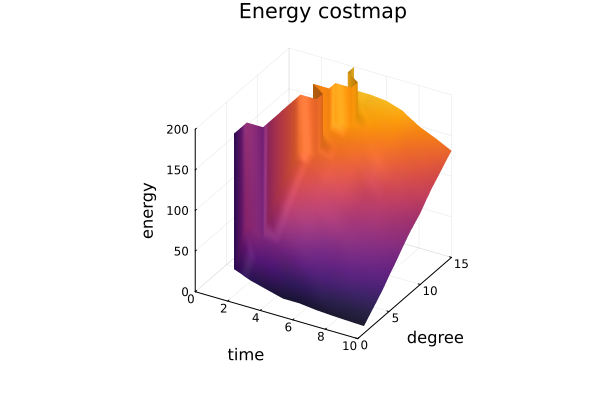

In [25]:
println(size(degree_list))
println(size(time_list))
println(size(LUT_viz))
plt = surface(
    LUT_viz,
    xlim = (0, time_range),
    ylim = (0, degree_range),
    zlim = (0, 200),
    title = "Energy costmap",
    legend = false,
    marker = 2,
    xlabel="time", ylabel="degree", zlabel="energy"
)

# using PlotlyJS
# plt = surface(x = degree_list, y = time_list, z = LUT_viz, colorscale="Viridis")
# plot(plt)



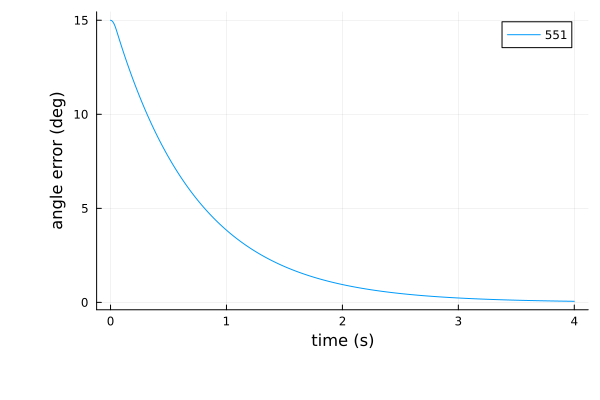

[2.4646307599782787e-5, 0.0, 0.0]
true
0.001009908739358615
0.075

In [27]:
let
    tf = 4
    dt = 0.01

    deviate_deg = 15
    p2 = 401
    p1 = 551
    
    converge_threshold_percent = 0.005
    converge_threshold = converge_threshold_percent * deviate_deg
    
    t_vec = 0:dt:tf
#         angle_error = simulate(deviate_deg, tf, dt, p1, p2)
    d = deg2rad(deviate_deg)
    results = simulate_exact_params(deg2rad(d), 0, 0, tf, dt, p1, p2, converge_threshold)
    angle_error = results[4]
    display(plot(t_vec, rad2deg.(angle_error), xlabel = "time (s)", ylabel = "angle error (deg)", label=string(p1), left_margin=50px, bottom_margin=50px))
    converged = results[1]
    println(results[5][5:7])
    println(converged)
    println(results[3])
    print(converge_threshold)
#      savefig(string(deviate_deg) * ".png")
end